In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/adityasyam/grg_pheno_sim') 

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.phenotype import convert_to_phen

from test_phenotype_sim.phenotype_test import test_variance


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct --no-maf-flip -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [-7.42769169e-02 -1.44604911e+00 -3.73235562e-01 -6.28100938e-01
  5.18785558e-01 -1.41176203e+00 -1.65521085e-01 -2.33655830e-01
  1.17082406e+00 -1.20657764e-01  6.75638729e-01 -4.65343533e-01
  1.73082180e+00 -1.53253804e+00  6.00228297e-01 -9.90902594e-01
  1.63123671e+00  5.54154355e-01 -1.13766872e+00 -8.19419663e-01
 -7.18037989e-01  3.03211827e-01 -5.09655597e-01 -3.03335640e-01
  6.64375792e-01  1.55377604e-01  1.06591393e+00  6.52865424e-01
  7.00810335e-02  2.40952586e-01 -1.32349178e-01  5.65356261e-01
 -8.46470173e-01 -3.50249794e-01 -1.88146376e-01 -4.19337482e-01
  2.26330377e+00  1.26814842e+00 -6.06961584e-01 -4.04744978e-01
 -1.12633329e+00  7.66989304e-02  4.31534836e-01  9.43106719e-01
  5.47411056e-01  1.97953073e+00 -1.64838800e+00  9.00744603e-01
  9.81552343e-01  1.36121405e+00 -9.39703337e-01  1.45852376e+00
 -6.02019422e-01  1.66780977e+00 -1.68175014e+00 -1.27401271e+00
 -1.16308010e-01  8.04200666e-01  1.11278869e+00  3.78507922e-01
 

In [5]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)

In [6]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #non-normalized genetic value df
individual_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


We first show how to simulate environmental noise before the genetic values have been normalized, with a narrow-sense heritability of 0.5.

In [7]:
phenotypes = sim_env_noise(individual_genetic_value_df, h2=0.5) #simulating environmental noise without normalizing genetic values
phenotype_df = phenotypes.phenotype_df
phenotype_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,-14.416315,-30.917979
1,0,1,-2.454348,-1.055210,-3.509558
2,0,2,-17.303803,7.205696,-10.098107
3,0,3,6.641214,-7.863231,-1.222017
4,0,4,-8.710213,6.560235,-2.149978
...,...,...,...,...,...
195,0,195,12.536488,9.901281,22.437769
196,0,196,16.549154,10.048198,26.597352
197,0,197,5.463626,-20.656172,-15.192547
198,0,198,-0.663779,3.061551,2.397772


In [8]:
h2_used = phenotypes.get_h2() #showing the h2 factor used, can be acccessed since it is a class attribute of phenotypes
print(h2_used)

[0.5]


In [9]:
phenotype_df = normalize(phenotypes)
test1 = test_variance(phenotype_df)
print("Variance of the phenotypes is " + str(phenotype_df['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df['environmental_noise'].var()))
print(test1)   #tests the variance condition in the phenotypic data, expected value close to zero
phenotype_df

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.550405992377877
Variance of the noise is 0.5580469402580297
-0.1084529326359065


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.278632,-0.736749,-1.015380
1,0,1,0.509225,0.012621,0.521846
2,0,2,-0.323620,0.475942,0.152321
3,0,3,1.019358,-0.369213,0.650145
4,0,4,0.158359,0.439740,0.598100
...,...,...,...,...,...
195,0,195,1.350000,0.627126,1.977126
196,0,196,1.575054,0.635366,2.210420
197,0,197,0.953312,-1.086717,-0.133405
198,0,198,0.609651,0.243513,0.853164


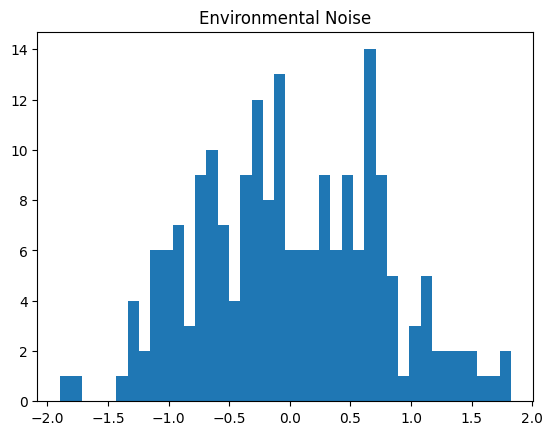

Mean of noise: -2.6645352591003756e-17
Standard deviation of noise: 0.7470253946540437


In [10]:

plt.hist(phenotype_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df['environmental_noise'].std()))

Now, we show a sample where zero noise is simulated (h2=1) by default.

In [11]:
phenotypes_zero_noise = sim_env_noise(individual_genetic_value_df) #simulating environmental noise without normalizing genetic values
phenotype_df_zero_noise = phenotypes_zero_noise.phenotype_df
phenotype_df_zero_noise

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-16.501664
1,0,1,-2.454348,0.0,-2.454348
2,0,2,-17.303803,0.0,-17.303803
3,0,3,6.641214,0.0,6.641214
4,0,4,-8.710213,0.0,-8.710213
...,...,...,...,...,...
195,0,195,12.536488,0.0,12.536488
196,0,196,16.549154,0.0,16.549154
197,0,197,5.463626,0.0,5.463626
198,0,198,-0.663779,0.0,-0.663779


In [12]:
phenotype_df_zero_noise = normalize(phenotypes_zero_noise)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise['environmental_noise'].var()))
phenotype_df_zero_noise

Variance of the phenotypes is 1.0
Variance of the genetic values is 174.97473363027564
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-0.375568
1,0,1,-2.454348,0.0,0.686386
2,0,2,-17.303803,0.0,-0.436209
3,0,3,6.641214,0.0,1.373995
4,0,4,-8.710213,0.0,0.213453
...,...,...,...,...,...
195,0,195,12.536488,0.0,1.819668
196,0,196,16.549154,0.0,2.123019
197,0,197,5.463626,0.0,1.284972
198,0,198,-0.663779,0.0,0.821750


In [13]:
phenotype_df_zero_noise_genetic_normalize = normalize(phenotypes_zero_noise, normalize_genetic_values=True)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise_genetic_normalize['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise_genetic_normalize['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise_genetic_normalize['environmental_noise'].var()))
phenotype_df_zero_noise_genetic_normalize


Variance of the phenotypes is 1.0
Variance of the genetic values is 1.0
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.0,-0.375568
1,0,1,0.686386,0.0,0.686386
2,0,2,-0.436209,0.0,-0.436209
3,0,3,1.373995,0.0,1.373995
4,0,4,0.213453,0.0,0.213453
...,...,...,...,...,...
195,0,195,1.819668,0.0,1.819668
196,0,196,2.123019,0.0,2.123019
197,0,197,1.284972,0.0,1.284972
198,0,198,0.821750,0.0,0.821750


Now, we simulate environmental noise before the genetic values have been normalized, with user defined noise. If user_defined is set to True, the user must specify mean and std values to be simulated from.

In [14]:
phenotype_non_normalized_user_defined = sim_env_noise(individual_genetic_value_df, user_defined=True, mean=0, std=1) #simulating standard noise on the non-normalized genetic values
phenotype_df_non_normalized_user_defined = phenotype_non_normalized_user_defined.phenotype_df
phenotype_df_non_normalized_user_defined

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,-1.208528,-17.710191
1,0,1,-2.454348,1.334256,-1.120092
2,0,2,-17.303803,1.536894,-15.766909
3,0,3,6.641214,-1.641164,5.000050
4,0,4,-8.710213,1.461375,-7.248837
...,...,...,...,...,...
195,0,195,12.536488,-0.275113,12.261376
196,0,196,16.549154,-0.681969,15.867185
197,0,197,5.463626,0.409240,5.872865
198,0,198,-0.663779,0.155063,-0.508716


The user can choose to view the h2 narrow sense heritability factor for the user-defined noise as well.

In [15]:
h2_user_defined = phenotype_non_normalized_user_defined.get_h2()
print(h2_user_defined)

0.9985572043111485


In [16]:
phenotype_df_non_normalized_user_defined = normalize(phenotype_non_normalized_user_defined)
print("Variance of the phenotypes is " + str(phenotype_df_non_normalized_user_defined['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_non_normalized_user_defined['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].var()))
phenotype_df_non_normalized_user_defined

Variance of the phenotypes is 0.9999999999999997
Variance of the genetic values is 0.9933593811853725
Variance of the noise is 0.005197823125775737


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.374319,-0.091795,-0.466114
1,0,1,0.684103,0.099796,0.783899
2,0,2,-0.434758,0.115064,-0.319693
3,0,3,1.369426,-0.124392,1.245033
4,0,4,0.212743,0.109374,0.322117
...,...,...,...,...,...
195,0,195,1.813616,-0.021465,1.792152
196,0,196,2.115958,-0.052120,2.063838
197,0,197,1.280698,0.030099,1.310797
198,0,198,0.819017,0.010948,0.829965


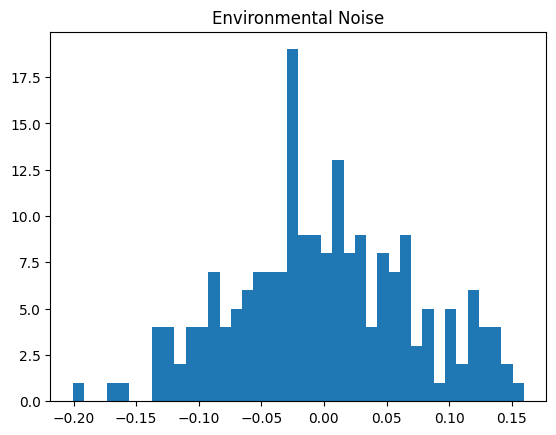

Mean of noise: -1.1102230246251566e-18
Standard deviation of noise: 0.07209593002226782


In [17]:

plt.hist(phenotype_df_non_normalized_user_defined["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].std()))

The user could also define a custom distribution to simulate environmental noise from.

In [18]:
genetic_val_df_normalized = normalize_genetic_values(individual_genetic_value_df) #normalized genetic value df
genetic_val_df_normalized

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


We now show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 0.25.

In [19]:
phenotype_post_normalization_h2 = sim_env_noise(genetic_val_df_normalized, h2=0.25) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization_h2 = phenotype_post_normalization_h2.phenotype_df
phenotype_df_post_normalization_h2

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,3.571672,3.196103
1,0,1,0.686386,-0.427601,0.258785
2,0,2,-0.436209,1.382721,0.946512
3,0,3,1.373995,0.441270,1.815265
4,0,4,0.213453,-2.081242,-1.867789
...,...,...,...,...,...
195,0,195,1.819668,-0.281822,1.537847
196,0,196,2.123019,-1.953707,0.169312
197,0,197,1.284972,2.098044,3.383015
198,0,198,0.821750,1.482916,2.304666


In [20]:
phenotype_df_post_normalization_h2 = normalize(phenotype_post_normalization_h2)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_h2['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_h2['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_h2['environmental_noise'].var()))
test3 = test_variance(phenotype_df_post_normalization_h2)
print(test3)  #tests the variance condition in the phenotypic data, expected value is close to zero
phenotype_df_post_normalization_h2

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.23460352564928283
Variance of the noise is 0.7993809634840254
-0.033984489133308315


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.181910,1.729528,1.547619
1,0,1,0.332457,-0.207555,0.124902
2,0,2,-0.211281,0.669291,0.458009
3,0,3,0.665507,0.213290,0.878797
4,0,4,0.103388,-1.008510,-0.905123
...,...,...,...,...,...
195,0,195,0.881373,-0.136945,0.744427
196,0,196,1.028303,-0.946738,0.081565
197,0,197,0.622387,1.015764,1.638151
198,0,198,0.398022,0.717821,1.115843


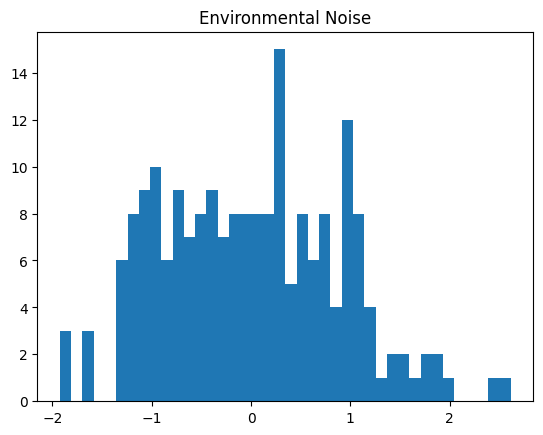

Mean of noise: 8.881784197001253e-18
Standard deviation of noise: 0.8940810720980651


In [21]:

plt.hist(phenotype_df_post_normalization_h2["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].std()))

We finally show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 1 (default case) and user defined cases for the noise.

In [22]:
phenotype_post_normalization_default_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=0, std=1) #simulating noise after genetic values have been normalized with h2=1 and user defined with standard mean and std
phenotype_df_post_normalization_default_mean_and_std = phenotype_post_normalization_default_mean_and_std.phenotype_df
phenotype_df_post_normalization_default_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,-0.254117,-0.629685
1,0,1,0.686386,1.088284,1.774670
2,0,2,-0.436209,0.362918,-0.073290
3,0,3,1.373995,-0.235562,1.138433
4,0,4,0.213453,1.036945,1.250398
...,...,...,...,...,...
195,0,195,1.819668,1.283324,3.102993
196,0,196,2.123019,1.733390,3.856409
197,0,197,1.284972,-1.377766,-0.092795
198,0,198,0.821750,0.277510,1.099260


In [23]:
phenotype_df_post_normalization_default_mean_and_std = normalize(phenotype_post_normalization_default_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_default_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_default_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].var()))
phenotype_df_post_normalization_default_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.4763213565282735
Variance of the noise is 0.4296545432027844


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.259202,-0.157947,-0.417150
1,0,1,0.473716,0.768525,1.242241
2,0,2,-0.301054,0.267906,-0.033148
3,0,3,0.948277,-0.145141,0.803136
4,0,4,0.147317,0.733092,0.880409
...,...,...,...,...,...
195,0,195,1.255863,0.903134,2.158997
196,0,196,1.465224,1.213751,2.678975
197,0,197,0.886836,-0.933445,-0.046609
198,0,198,0.567139,0.208961,0.776100


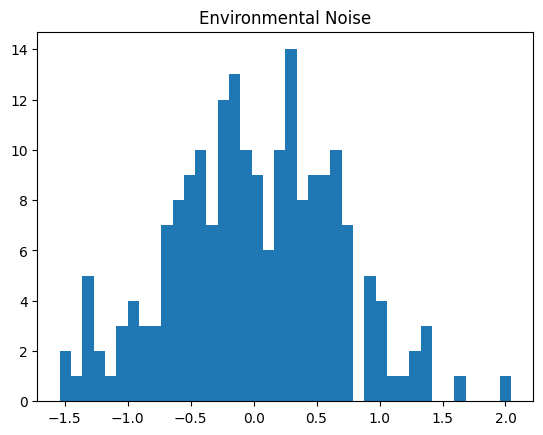

Mean of noise: 5.551115123125783e-18
Standard deviation of noise: 0.6554803911657345


In [24]:

plt.hist(phenotype_df_post_normalization_default_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_unique_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=1, std=2) #simulating noise after genetic values have been normalized with h2=1 and user defined mean and std
phenotype_df_post_normalization_unique_mean_and_std = phenotype_post_normalization_unique_mean_and_std.phenotype_df
phenotype_df_post_normalization_unique_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,-0.307257,-0.682825
1,0,1,0.686386,1.390192,2.076577
2,0,2,-0.436209,1.944097,1.507888
3,0,3,1.373995,2.562103,3.936098
4,0,4,0.213453,-0.355430,-0.141977
...,...,...,...,...,...
195,0,195,1.819668,1.144494,2.964162
196,0,196,2.123019,0.860044,2.983063
197,0,197,1.284972,-3.097107,-1.812136
198,0,198,0.821750,0.264954,1.086704


In [26]:
phenotype_df_post_normalization_unique_mean_and_std = normalize(phenotype_post_normalization_unique_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_unique_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_unique_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].var()))
test5 = test_variance(phenotype_df_post_normalization_unique_mean_and_std)
phenotype_df_post_normalization_unique_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.1920372661313475
Variance of the noise is 0.8210675900781464


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.164582,-0.533974,-0.698555
1,0,1,0.300788,0.209883,0.510672
2,0,2,-0.191156,0.452616,0.261460
3,0,3,0.602113,0.723439,1.325552
4,0,4,0.093539,-0.555084,-0.461545
...,...,...,...,...,...
195,0,195,0.797416,0.102213,0.899629
196,0,196,0.930351,-0.022438,0.907912
197,0,197,0.563101,-1.756544,-1.193443
198,0,198,0.360108,-0.283219,0.076889


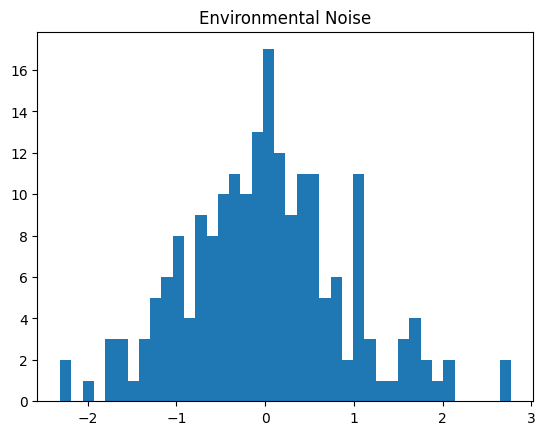

Mean of noise: -2.6645352591003756e-17
Standard deviation of noise: 0.9061278000801799


In [27]:

plt.hist(phenotype_df_post_normalization_unique_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].std()))

We show an example of converting the final phenotypes output to a standard .phen file format to be saved in the local directory.

In [28]:
local_path = 'post_noise_phenotypes.phen' #will be saved in a .phen file of this name in the local directory.
convert_to_phen(phenotype_df_post_normalization_unique_mean_and_std, local_path, include_header=True)